### U-net architecture neural network for image segmentation of CT scans using google colab

In [2]:
! pip install pydicom
import matplotlib.pyplot as plt
import pydicom
import pydicom.data
import os, re
import pandas as pd
import pprint
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.transform import rescale

import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AlphaDropout, concatenate, Conv2DTranspose, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop  
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.backend import  mean, abs, sum, round, clip, epsilon, flatten

In [1]:
# import google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### load train and test data from google drive: 

In [3]:
orig_train = np.load('/content/drive/MyDrive/data/X_train_19_patients_128.pkl', allow_pickle=True)

In [4]:
masks_train = np.load('/content/drive/MyDrive/data/y_train_19_patients_128.pkl', allow_pickle=True)

In [5]:
orig_test = np.load('/content/drive/MyDrive/data/X_test_19_patients_128.pkl', allow_pickle=True)

In [6]:
masks_test = np.load('/content/drive/MyDrive/data/y_test_19_patients_128.pkl', allow_pickle=True)

the model: 

In [8]:
imgWidth = 128
imgHeight = 128
imgChannels = 1

In [10]:
# build U-net architecture model: 
inputs = Input((imgWidth, imgHeight, imgChannels), name = 'input')

c1 = Conv2D(16, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c1-1")(inputs)
d1 = AlphaDropout(0.05, name = "d1")(c1)
c1 = Conv2D(16, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c1-2")(d1)
p1 = MaxPooling2D((2,2), name = "p1")(c1)

c2 = Conv2D(32, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c2-1")(p1)
d2 = AlphaDropout(0.05, name = "d2")(c2)
c2 = Conv2D(32, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c2-2")(d2)
p2 = MaxPooling2D((2,2), name = "p2")(c2)

c3 = Conv2D(64, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c3-1")(p2)
d3 = AlphaDropout(0, name = 'd3')(c3)
c3 = Conv2D(64, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c3-2")(d3)
p3 = MaxPooling2D((2,2), name = "p3")(c3)

c4 = Conv2D(128, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c4-1")(p3)
d4 = AlphaDropout(0.05, name = "d4")(c4)
c4 = Conv2D(128, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c4-2")(d4)
p4 = MaxPooling2D((2,2), name = "p4")(c4)

c5 = Conv2D(256, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c5-1")(p4)
d5 = AlphaDropout(0, name = "d5")(c5)
c5 = Conv2D(256, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c5-2")(d5)
u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same', name = "t1")(c5)

u6 = concatenate([u6, c4], name = "cc1")
c6 = Conv2D(128, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c6-1")(u6)
d6 = AlphaDropout(0, name = "d6")(c6)
c6 = Conv2D(128, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c6-2")(d6)
u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same', name = "t2")(c6)

u7 = concatenate([u7, c3], name = "cc2")
c7 = Conv2D(64, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c7-1")(u7)
d7 = AlphaDropout(0.05, name = "d7")(c7)
c7 = Conv2D(64, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c7-2")(d7)
u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same', name = "t3")(c7)

u8 = concatenate([u8, c2], name = "cc3")
c8 = Conv2D(32, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c8-1")(u8)
d8 = AlphaDropout(0, name = "d8")(c8)
c8 = Conv2D(32, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c8-2")(d8)
u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same', name = "t4")(c8)

u9 = concatenate([u9, c1], name = "cc4")
c9 = Conv2D(16, (3,3), activation='selu', kernel_initializer='lecun_normal', padding='same', name = "c9-1")(u9)
d9 = AlphaDropout(0.05, name = "d9")(c9)
c10 = Conv2D(16, (1,1), strides=(1,1), padding='same', name = "c10")(d9)

outputs = Conv2D(1,(1,1), activation='sigmoid', name = "output")(c10)

model = Model(inputs=[inputs], outputs=[outputs])

In [12]:
# metrics: 
def diceCoef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def diceCoefLoss(y_true, y_pred):
    return (1-diceCoef(y_true, y_pred))

def jaccardDistance(y_true, y_pred, smooth=1):
    intersection = sum(abs(y_true * y_pred), axis=-1)
    sum_ = sum(abs(y_true) + abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1-jac) * smooth

def f1Score(y_true, y_pred):
    true_positives = sum(round(clip(y_true * y_pred, 0, 1)))
    possible_positives = sum(round(clip(y_true, 0, 1)))
    predicted_positives = sum(round(clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + epsilon())
    recall = true_positives / (possible_positives + epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+epsilon())
    return f1_val

In [13]:
metrics = ['Accuracy', 'Precision', 'Recall', 'AUC', diceCoef, jaccardDistance, f1Score]

In [14]:
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss=diceCoefLoss , metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
c1-1 (Conv2D)                   (None, 128, 128, 16) 160         input[0][0]                      
__________________________________________________________________________________________________
d1 (AlphaDropout)               (None, 128, 128, 16) 0           c1-1[0][0]                       
__________________________________________________________________________________________________
c1-2 (Conv2D)                   (None, 128, 128, 16) 2320        d1[0][0]                         
______________________________________________________________________________________________

In [ ]:
K.clear_session()
results = model.fit(x=orig_train, y=masks_train, batch_size=100, epochs = 1500, verbose = 1, validation_split = 0.2) #, callbacks=[tensorboard_callback]) #train model

Epoch 1/3000
17/17 [==============================] - 12s 390ms/step - loss: 0.8242 - accuracy: 0.0000e+00 - precision: 0.1074 - recall: 0.8504 - auc: 0.7895 - diceCoef: 0.1759 - jaccardDistance: 0.2588 - f1Score: 0.2142 - val_loss: 0.8247 - val_accuracy: 0.0000e+00 - val_precision: 0.0967 - val_recall: 0.9946 - val_auc: 0.8666 - val_diceCoef: 0.1830 - val_jaccardDistance: 0.2524 - val_f1Score: 0.1837
Epoch 2/3000
17/17 [==============================] - 4s 249ms/step - loss: 0.5221 - accuracy: 0.0000e+00 - precision: 0.3844 - recall: 0.7399 - auc: 0.9053 - diceCoef: 0.4779 - jaccardDistance: 0.0514 - f1Score: 0.5110 - val_loss: 0.7827 - val_accuracy: 0.0000e+00 - val_precision: 0.1220 - val_recall: 0.9824 - val_auc: 0.8705 - val_diceCoef: 0.2264 - val_jaccardDistance: 0.1890 - val_f1Score: 0.2258
Epoch 3/3000
17/17 [==============================] - 4s 248ms/step - loss: 0.4279 - accuracy: 3.2100e-05 - precision: 0.4915 - recall: 0.7052 - auc: 0.8934 - diceCoef: 0.5721 - jaccardDistan

In [19]:
# evaluation:
evaluate = model.evaluate(orig_test, masks_test, batch_size = 8) #evaluate model

67/67 [==============================] - 1s 15ms/step - loss: 0.1149 - accuracy: 0.9816 - precision: 0.8304 - recall: 0.9697 - auc: 0.9800 - diceCoef: 0.8828 - jaccardDistance: 0.0061 - f1Score: 0.8829


In [20]:
# save model: 
model.save('/content/drive/MyDrive/data/model_best_128_patients_2.h5')

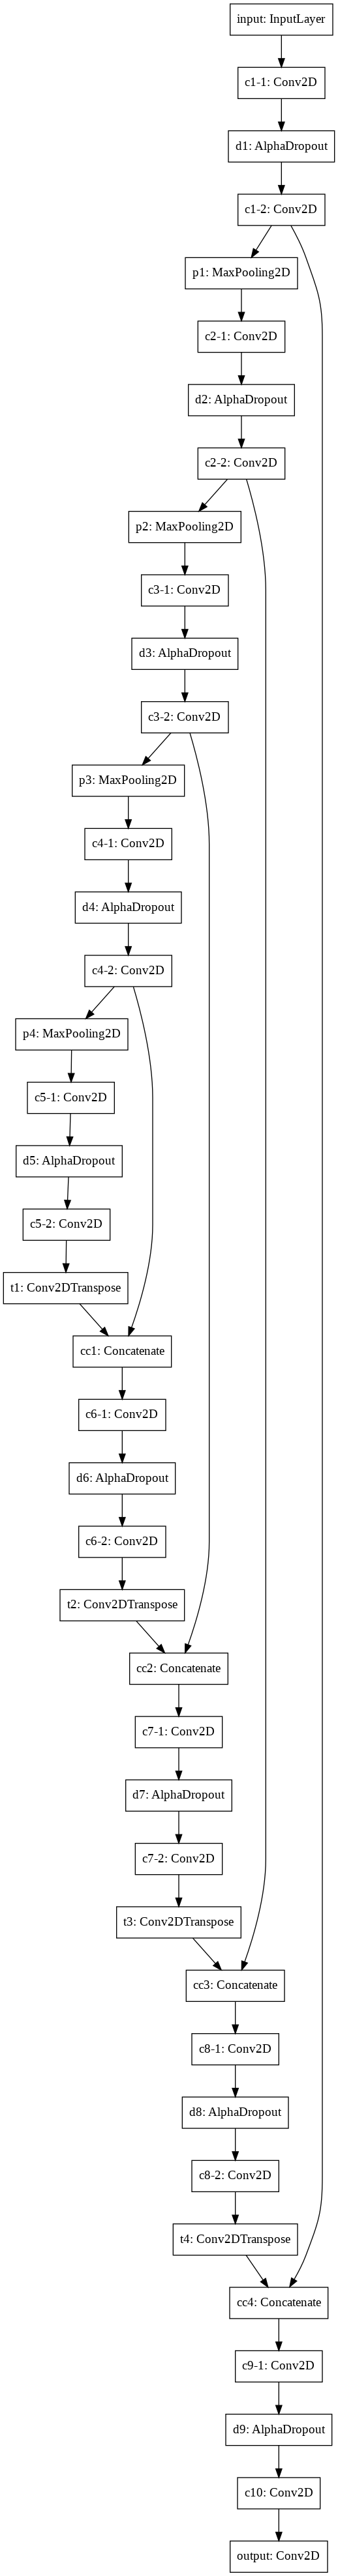

In [ ]:
# plot model architecture:
plot_model(model, to_file='/content/drive/MyDrive/data/model_best_128_patients_2.png')

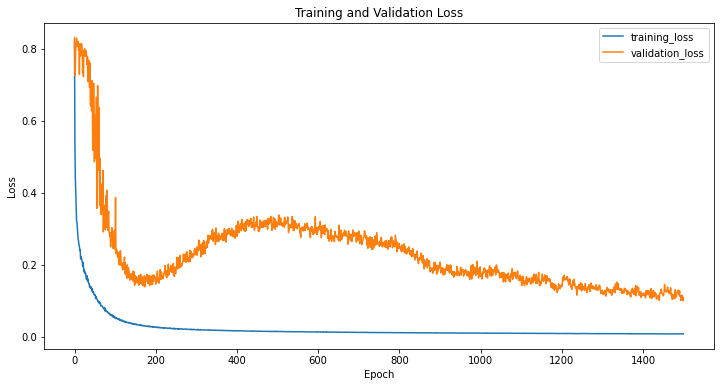

In [21]:
# plot loss function :
plt.rcParams['figure.figsize']=(12,6)

plt.plot(results.history['loss'], label='training_loss')
plt.plot(results.history['val_loss'], label='validation_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

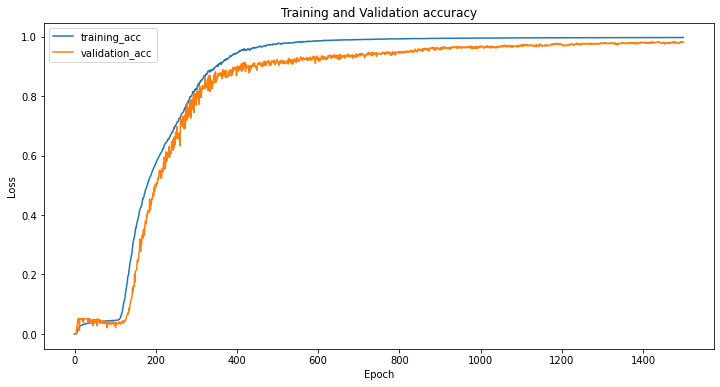

In [22]:
# plot accuracy
plt.rcParams['figure.figsize']=(12,6)

plt.plot(results.history['accuracy'], label='training_acc')
plt.plot(results.history['val_accuracy'], label='validation_acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

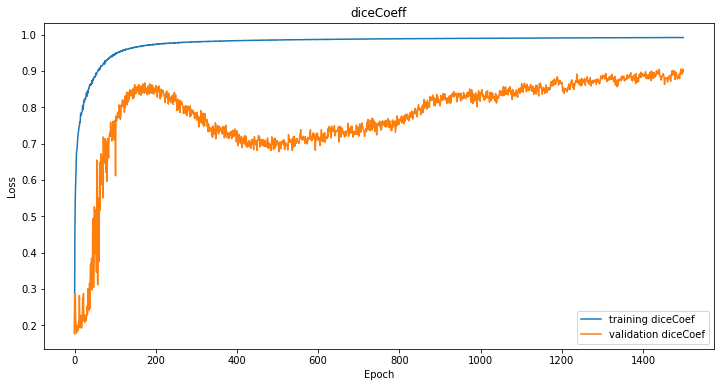

In [23]:
#plot dice coefficient: 
plt.rcParams['figure.figsize']=(12,6)
plt.plot(results.history['diceCoef'], label='training diceCoef')
plt.plot(results.history['val_diceCoef'], label='validation diceCoef')
plt.title('diceCoeff')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
#predict on test split:
preds = model.predict(orig_test)

In [25]:
preds[300].shape 

(128, 128, 1)

In [32]:
# reshape example prediction to plot: 
temp = preds[350].reshape(128, 128)
tempX = orig_test[350].reshape(128, 128)
tempy = masks_test[350].reshape(128, 128)

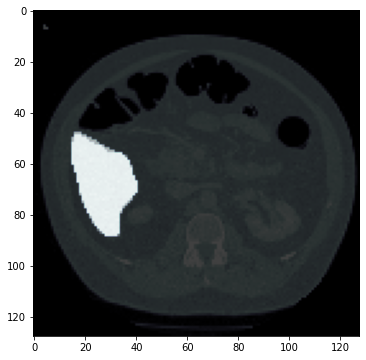

In [33]:
## plot example prediction: 
plt.imshow(tempX,  cmap=plt.cm.bone)  
plt.imshow(temp, cmap=plt.cm.bone, alpha=0.5) 
plt.imshow(tempy,cmap=plt.cm.bone, alpha=0.5 )
plt.show() 

In [28]:
# save predictions: 
np.save('/content/drive/MyDrive/data/preds_model_best_128_patients_2', preds, allow_pickle=True)